# **CommonLit Readability**

### **Import libraries**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import torch
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils import data
from torch import nn, optim
from collections import defaultdict
import warnings
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
pd.set_option("display.max_colwidth", None)

In [4]:
warnings.filterwarnings("ignore")

### **Load data**

#### Load and describe the training data

In [5]:
filename = "../input/commonlitreadabilityprize/train.csv"
df_train = pd.read_csv(filename)
df_train = df_train.drop(["url_legal", "license"], axis = 1)

In [6]:
df_train.head(1)

,id,excerpt,target,standard_error
0,c12129c31,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.",-0.340259,0.464009


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2834 non-null   object 
 1   excerpt         2834 non-null   object 
 2   target          2834 non-null   float64
 3   standard_error  2834 non-null   float64
dtypes: float64(2), object(2)
memory usage: 88.7+ KB


In [8]:
df_train['target'].describe()

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64

In [9]:
std = df_train['target'].std()
mean = df_train['target'].mean()
print('mean:', mean)
print('std: ', std)

mean: -0.9593187699947071
std:  1.0335792017597232


#### Load the test data

In [10]:
filename = "../input/commonlitreadabilityprize/test.csv"
df_test = pd.read_csv(filename)
df_test = df_test.drop(["url_legal", "license"], axis = 1)

In [11]:
df_test.head(1)

,id,excerpt
0,c0f722661,"My hope lay in Jack's promise that he would keep a bright light burning in the upper story to guide me on my course. On a clear night this light was visible from the village, but somehow or other I failed to take into account the state of the weather. The air was full of eddying flakes, which would render the headlight of a locomotive invisible a hundred yards distant. Strange that this important fact never occurred to me until I was fully a fourth of a mile from the village. Then, after looking in vain for the beacon light, the danger of my situation struck me, and I halted.\n""I am certain to go wrong,"" I said to myself.\n""It is out of my power to follow a direct course without something to serve as a compass. I will go back to the village and wait till morning."""


### **Transform data**

#### Remove new lines

In [12]:
def to_string(row_text):
  lines = row_text.split('\n')
  string = ""
  for line in lines:
    string = string + " " + line
  return string

#### Remove new lines from the training data

In [13]:
df_train['excerpt'] = df_train['excerpt'].apply(to_string)

In [14]:
df_train.head(1)

,id,excerpt,target,standard_error
0,c12129c31,"When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape. The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches. At each end of the room, on the wall, hung a beautiful bear-skin rug. These rugs were for prizes, one for the girls and one for the boys. And this was the game. The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole. This would have been an easy matter, but each traveller was obliged to wear snowshoes.",-0.340259,0.464009


#### Remove new lines from the test data

In [15]:
df_test['excerpt'] = df_test['excerpt'].apply(to_string)

In [16]:
df_test.head(1)

,id,excerpt
0,c0f722661,"My hope lay in Jack's promise that he would keep a bright light burning in the upper story to guide me on my course. On a clear night this light was visible from the village, but somehow or other I failed to take into account the state of the weather. The air was full of eddying flakes, which would render the headlight of a locomotive invisible a hundred yards distant. Strange that this important fact never occurred to me until I was fully a fourth of a mile from the village. Then, after looking in vain for the beacon light, the danger of my situation struck me, and I halted. ""I am certain to go wrong,"" I said to myself. ""It is out of my power to follow a direct course without something to serve as a compass. I will go back to the village and wait till morning."""


### **Exploratory Data Analysis**

In [17]:
sns.set_style("darkgrid")
rcParams['figure.figsize'] = 9, 6

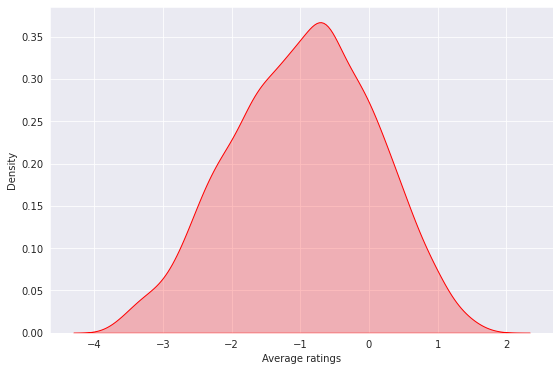

In [18]:
sns.kdeplot(df_train.target, shade=True, color="r")
plt.xlabel('Average ratings')
plt.show()

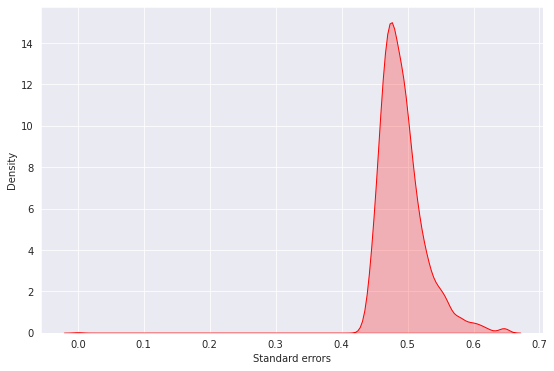

In [19]:
sns.kdeplot(df_train.standard_error, shade=True, color="r")
plt.xlabel('Standard errors')
plt.show()

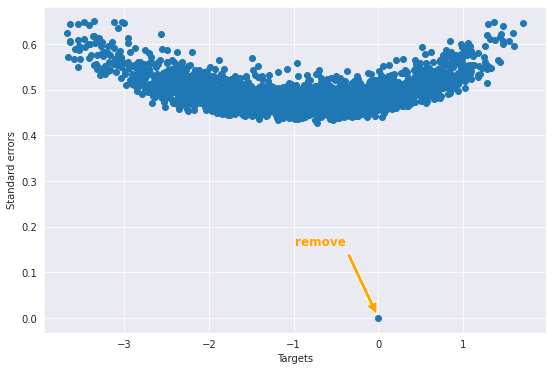

In [20]:
x=df_train['target']
y=df_train['standard_error']
plt.scatter(x=x, y=y)
plt.annotate("remove", xy=(0, 0), arrowprops=dict(facecolor='orange', shrink=0.05), 
             xytext=(0.6, 0.3), textcoords='axes fraction', fontsize=12, weight='bold',
             horizontalalignment='right', verticalalignment='top', color='orange')
plt.xlabel('Targets')
plt.ylabel('Standard errors')
plt.show()

In [21]:
ind = df_train[df_train['target'] == 0].index
df_train = df_train.drop(ind)

In [22]:
lower_bound = mean - std
upper_bound = mean + std
lower_bound, upper_bound

(-1.9928979717544304, 0.07426043176501607)

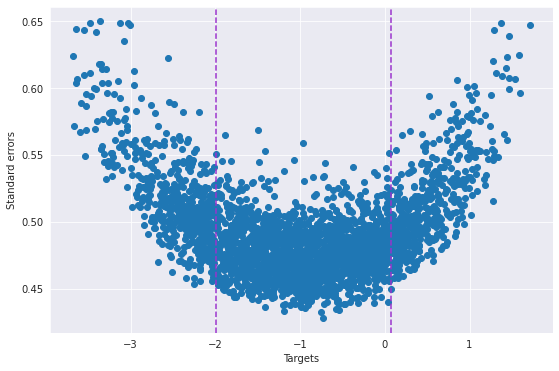

In [23]:
plt.scatter(x=df_train['target'], y=df_train['standard_error'])

plt.axvline(x=lower_bound, ymin=0, ymax=1, linewidth=1.5, linestyle="--", color='darkorchid')
plt.axvline(x=upper_bound, ymin=0, ymax=1, linewidth=1.5, linestyle="--", color='darkorchid')

plt.xlabel('Targets')
plt.ylabel('Standard errors')
plt.show()

In [24]:
min_value = df_train["target"].min()
max_value = df_train["target"].max()
print("min: ",  min_value)
print("max: ",  max_value)

min:  -3.676267773
max:  1.7113898269999999


### **Choose sequence length**

In [25]:
PRE_TRAINED_MODEL = "bert-base-uncased"

In [26]:
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

training data :
----------------------------------------------------------------------------------------------------
min ve max tokens: 156 312




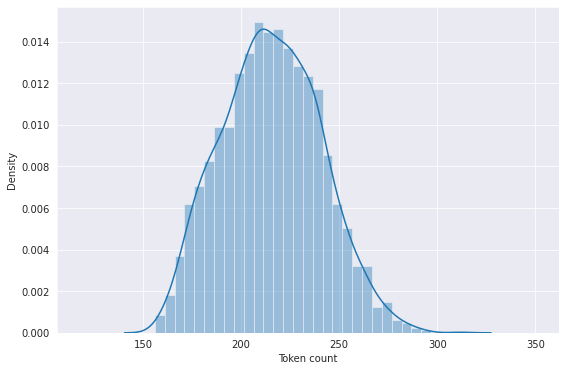



test data :
----------------------------------------------------------------------------------------------------
min ve max tokens: 172 235




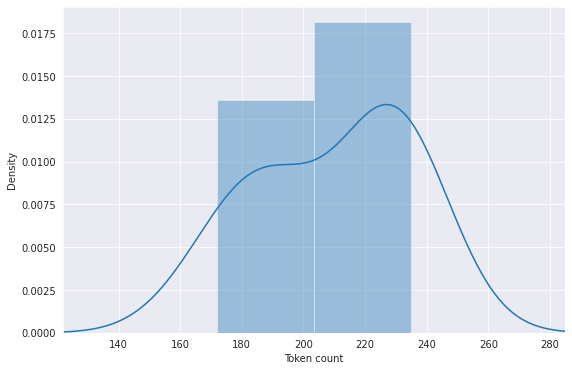



CPU times: user 14.8 s, sys: 14.4 ms, total: 14.8 s
Wall time: 14.8 s


In [27]:
%%time

for df in [("training data", df_train), ("test data", df_test)]:
  excerpt_tokens = []
  for excerpt in df[1].excerpt:
    tokens = tokenizer.tokenize(excerpt)
    excerpt_tokens.append(len(tokens))

  min_tokens = min(excerpt_tokens)
  max_tokens = max(excerpt_tokens)
  print(df[0],":")
  print("-" * 100)
  print('min ve max tokens:', min_tokens, max_tokens)
  print('\n')

  sns.distplot(excerpt_tokens)
  plt.xlim([min_tokens-50, max_tokens+50]);
  plt.xlabel('Token count');
  plt.show()

  print('\n')


### **Set parameters**

In [28]:
BS = 4
MAX_LEN = 320
EPOCHS = 5
RANDOM_SEED = 42
BIAS = False
SPLIT_RATIO = 0.1
DROPOUT = 0.3

WD = 0
LEARNING_RATE = 2e-5
NUM_WARMUP_PERCENTAGE = 0.1

In [29]:
def define_scheduler(data_loader):

  total_steps = len(data_loader) * EPOCHS

  scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=int(NUM_WARMUP_PERCENTAGE*total_steps),
      num_training_steps=total_steps
  )

  return scheduler

### **Train-validation split**

In [30]:
def split_train_val(full_data, SPLIT_RATIO):
  df_train, df_val = train_test_split(
      full_data,
      test_size=SPLIT_RATIO,
      random_state=RANDOM_SEED
      )

  print("training data:", df_train.shape)
  print("validation data:", df_val.shape)

  return df_train, df_val

### **Encoding**

#### Encode train excerpts.

In [31]:
class ExcerptDataset(data.Dataset):
  def __init__(self, ids, excerpts, targets, tokenizer, max_len):
    self.ids = ids
    self.excerpts = excerpts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.excerpts)

  def __getitem__(self, item):
    id = str(self.ids[item])
    excerpt = str(self.excerpts[item])
    target = self.targets[item]

    encoding = tokenizer.encode_plus(
        excerpt,
        max_length=self.max_len,
        truncation=True,
        add_special_tokens=True,
        pad_to_max_length=True,
        return_attention_mask=True, 
        return_token_type_ids=False,
        return_tensors='pt'
    )

    return {
      'id': id,
      'excerpt_text': excerpt,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.float)
    }

In [32]:
df_train_set, df_val_set = split_train_val(df_train, SPLIT_RATIO)

training data: (2549, 4)
validation data: (284, 4)


### **Create data loaders**

In [33]:
def create_data_loader(df, tokenizer, MAX_LEN, batch_size=4, shuffle=True):
  dataset = ExcerptDataset(
    ids = df.id.to_numpy(),
    excerpts=df.excerpt.to_numpy(),
    targets=df.target.to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
  )

  data_loader = data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=2
  )

  data_item = next(iter(data_loader))

  print(data_item.keys())
  print('\n')
  print(data_item['input_ids'].shape)
  print(data_item['attention_mask'].shape)
  print(data_item['targets'].shape)
  print('\n')
  print("input_ids:", data_item['input_ids'])
  print("attention_mask:", data_item['attention_mask'])
  print("targets:", data_item['targets'])

  return data_loader

In [34]:
train_data_loader = create_data_loader(df_train_set, tokenizer, MAX_LEN, batch_size=BS, shuffle=True)
val_data_loader = create_data_loader(df_val_set, tokenizer, MAX_LEN, batch_size=BS, shuffle=True)

dict_keys(['id', 'excerpt_text', 'input_ids', 'attention_mask', 'targets'])


torch.Size([4, 320])
torch.Size([4, 320])
torch.Size([4])


input_ids: tensor([[  101,  1999,  2220,  ...,     0,     0,     0],
        [  101,  2004,  2009,  ...,     0,     0,     0],
        [  101,  1996,  3160,  ...,     0,     0,     0],
        [  101,  1037, 23159,  ...,     0,     0,     0]])
attention_mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
targets: tensor([-0.3593, -0.1079, -3.4733,  0.4690])
dict_keys(['id', 'excerpt_text', 'input_ids', 'attention_mask', 'targets'])


torch.Size([4, 320])
torch.Size([4, 320])
torch.Size([4])


input_ids: tensor([[ 101, 1996, 2744,  ...,    0,    0,    0],
        [ 101, 1048, 1012,  ...,    0,    0,    0],
        [ 101, 2007, 5760,  ...,    0,    0,    0],
        [ 101, 1999, 1037,  ...,    0,    0,    0]])
attention_mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
   

### **Regression**

#### Regression model

In [35]:
class ExcerptRegression(nn.Module):

  def __init__(self, DROPOUT):
    super(ExcerptRegression, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL)
    self.drop = nn.Dropout(p=DROPOUT)
    self.linear = nn.Linear(self.bert.config.hidden_size, 1)

  def forward(self, input_ids, attention_mask):
    _, output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict = False)
    output = self.drop(output)
    output = self.linear(output)

    return output

In [36]:
reg_model = ExcerptRegression(DROPOUT)
reg_model = reg_model.to(device)

#### Define loss function RMSE

In [37]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()
        self.mse = nn.MSELoss()

    def forward(self,pred,y):
        loss_fn = torch.sqrt(self.mse(pred, y))
        return loss_fn

#### Optimizer

In [38]:
optimizer = AdamW(reg_model.parameters(), lr=LEARNING_RATE, correct_bias=BIAS, weight_decay=WD)

loss_fn = RMSELoss().to(device)

### **Training the data**

In [39]:
def train(reg_model, data_loader, loss_fn, optimizer, device):

  scheduler = define_scheduler(data_loader)
  reg_model = reg_model.train()
  losses = []

  for dl in data_loader:
    input_ids = dl["input_ids"].to(device)
    attention_mask = dl["attention_mask"].to(device)
    targets = dl["targets"].to(device)
    
    outputs = reg_model(
      input_ids=input_ids,
      attention_mask=attention_mask,
    )

    loss = loss_fn(outputs.view(-1), targets.view(-1)) # pred, y
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(reg_model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return np.mean(losses)

### **Evaluation**

In [40]:
def evaluate(reg_model, data_loader, loss_fn, device):

  reg_model = reg_model.eval()
  losses = []

  with torch.no_grad():

    for dl in data_loader:
      input_ids = dl["input_ids"].to(device)
      attention_mask = dl["attention_mask"].to(device)
      targets = dl["targets"].to(device)

      outputs = reg_model(
        input_ids=input_ids,
        attention_mask=attention_mask,
      )

      loss = loss_fn(outputs.view(-1), targets.view(-1)) 
      losses.append(loss.item())

  return np.mean(losses)

### **Run the model**

In [44]:
%%time

epoch_results = defaultdict(list)
min_loss = 1000.0

print("TRAINING RESULTS:")
print('*' * 50)
print('\n')

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 50)

  train_loss = train(reg_model, train_data_loader, loss_fn, optimizer, device)

  print(f'Training   loss: {train_loss}')
  print('\n')
 
  val_loss = evaluate(reg_model, val_data_loader, loss_fn, device)

  print(f'Validation loss: {val_loss}')
  print('\n')

  epoch_results['train_loss'].append(train_loss)
  epoch_results['validation_loss'].append(val_loss)
  
  if val_loss < min_loss:
    name = "1set_best_model_1.pt"
    torch.save(reg_model.state_dict(), './' + name)
    min_loss = val_loss

TRAINING RESULTS:
**************************************************


Epoch 1/5
--------------------------------------------------
Training   loss: 0.22739275238333637


Validation loss: 0.5194880381016664


Epoch 2/5
--------------------------------------------------
Training   loss: 0.21443648910482754


Validation loss: 0.5282892983564189


Epoch 3/5
--------------------------------------------------
Training   loss: 0.19265560505088408


Validation loss: 0.5008674535742947


Epoch 4/5
--------------------------------------------------
Training   loss: 0.18990750689947025


Validation loss: 0.5825649136808556


Epoch 5/5
--------------------------------------------------
Training   loss: 0.1870709970815335


Validation loss: 0.5337520052849407


CPU times: user 9min 41s, sys: 4.99 s, total: 9min 46s
Wall time: 9min 57s


### **Plot the results**

In [45]:
train_loss = epoch_results['train_loss']
validation_loss = epoch_results['validation_loss']

min_train_loss= min(train_loss)
min_val_lost = min(validation_loss)

val_index = validation_loss.index(min_val_lost)

print("model: ", PRE_TRAINED_MODEL)
print("batch size:", BS)
print("maximum sequence length:", MAX_LEN)
print("number of epochs:", EPOCHS)
print("random seed:", RANDOM_SEED)
print("learning rate:", LEARNING_RATE)
print("weight decay:", WD)
print("warmup percentage:", NUM_WARMUP_PERCENTAGE)
print("bias correction:", BIAS)
print("dropout:", DROPOUT)
print("split ratio:", SPLIT_RATIO)
print('\n')
print("minimum train loss:", min_train_loss)
print("minimum validation loss:", min_val_lost)

model:  bert-base-uncased
batch size: 4
maximum sequence length: 320
number of epochs: 5
random seed: 42
learning rate: 2e-05
weight decay: 0
warmup percentage: 0.1
bias correction: False
dropout: 0.3
split ratio: 0.1


minimum train loss: 0.1870709970815335
minimum validation loss: 0.5008674535742947


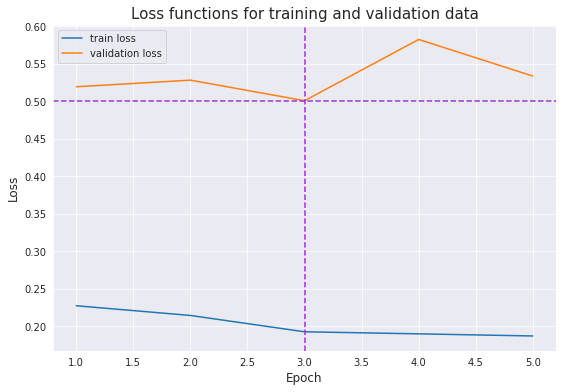

In [46]:
x = range(1, EPOCHS+1)
y1 = train_loss
y2 = validation_loss

plt.plot(x, y1, label='train loss')
plt.plot(x, y2, label='validation loss')

plt.title('Loss functions for training and validation data', fontsize=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.axvline(x=x[val_index], ymin=0, ymax=1, linewidth=1.5, linestyle="--", color='darkorchid')
plt.axhline(y=min_val_lost, linewidth=1.5, linestyle="--", color='darkorchid')

plt.show()

### **Predict the test data**

#### Load the best model

In [47]:
DROPOUT = 0

In [48]:
reg_model = ExcerptRegression(DROPOUT)
reg_model = reg_model.to(device)

#### Create data loader of the test data

In [49]:
df_test['target'] = 100

test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, batch_size=4, shuffle=False)

dict_keys(['id', 'excerpt_text', 'input_ids', 'attention_mask', 'targets'])


torch.Size([4, 320])
torch.Size([4, 320])
torch.Size([4])


input_ids: tensor([[  101,  2026,  3246,  ...,     0,     0,     0],
        [  101, 11089,  3723,  ...,     0,     0,     0],
        [  101,  2009,  2001,  ...,     0,     0,     0],
        [  101,  3526,  2407,  ...,     0,     0,     0]])
attention_mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
targets: tensor([100., 100., 100., 100.])


Predict

In [50]:
def find_predictions(reg_model, data_loader):

  id_data = []
  excerpt_data = []
  output_data = []

  reg_model = reg_model.eval()

  with torch.no_grad():
  
    for dl in data_loader:

      id = dl['id']
      excerpt = dl['excerpt_text']
      input_ids = dl["input_ids"].to(device)
      attention_mask = dl["attention_mask"].to(device)

      outputs = reg_model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      outputs = outputs.flatten().tolist()
      output_data.extend(outputs)
      excerpt_data.extend(excerpt)
      id_data.extend(id)

  return id_data, excerpt_data, output_data

In [51]:
id_data, excerpt_data, output_data = find_predictions(reg_model, test_data_loader)

In [52]:
predictions_df = pd.DataFrame(list(zip(id_data, excerpt_data, output_data)), columns =['id', 'excerpt', 'target'])
predictions_df

,id,excerpt,target
0,c0f722661,"My hope lay in Jack's promise that he would keep a bright light burning in the upper story to guide me on my course. On a clear night this light was visible from the village, but somehow or other I failed to take into account the state of the weather. The air was full of eddying flakes, which would render the headlight of a locomotive invisible a hundred yards distant. Strange that this important fact never occurred to me until I was fully a fourth of a mile from the village. Then, after looking in vain for the beacon light, the danger of my situation struck me, and I halted. ""I am certain to go wrong,"" I said to myself. ""It is out of my power to follow a direct course without something to serve as a compass. I will go back to the village and wait till morning.""",0.154990
1,f0953f0a5,"Dotty continued to go to Mrs. Gray's every night with the milk. Sometimes Katie went with her, and then they always paused a while under the acorn-tree and played ""King and Queen."" Dotty said she wished they could ever remember to bring their nipperkins, for in that case the milk would taste a great deal more like nectar. The ""nipperkins"" were a pair of handled cups which the children supposed to be silver, and which they always used at table. Dotty knew she was doing wrong every time she played ""King and Queen."" She knew the milk was not hers, but Mrs. Gray's; still she said to herself, ""Ruthie needn't give so much measure, all pressed down and run over. If Queenie and I should drink a great deal more, there would always be a quart left. Yes, I know there would."" Mrs. Gray never said anything about the milk; she merely poured it out in a pan, and gave back the pail to Dotty, asking her at the same time as many questions as the child would stay to hear.",0.131687
2,0df072751,"It was a bright and cheerful scene that greeted the eyes of Captain Raymond and his son as they entered the parlor of the adjacent cottage. It was strictly a family gathering, yet the room was quite full. Mr. Dinsmore was there with his wife, his daughter Elsie and her children, Edward and Zoe, Elsie Leland with her husband and babe, Violet Raymond with her husband's two little girls, Lulu and Grace, and lastly Rosie and Walter. Everybody had a kindly greeting for the captain, and Violet's bright face grew still brighter as she made room for him on the sofa by her side. ""We were beginning to wonder what was keeping you,"" she said. ""Yes, I'm afraid I am rather behind time,"" he returned. ""I hope you have not delayed your tea for me, Mrs. Dinsmore."" ""No; it is but just ready,"" she said. ""Ah, there's the bell. Please, all of you walk out."" When the meal was over all returned to the parlor, where they spent the next hour in desultory chat.",0.310649
3,04caf4e0c,"Cell division is the process by which a parent cell divides into two or more daughter cells. Cell division usually occurs as part of a larger cell cycle. In eukaryotes, there are two distinct types of cell division: a vegetative division, whereby each daughter cell is genetically identical to the parent cell (mitosis), and a reproductive cell division, whereby the number of chromosomes in the daughter cells is reduced by half, to produce haploid gametes (meiosis). Meiosis results in four haploid daughter cells by undergoing one round of DNA replication followed by two divisions: homologous chromosomes are separated in the first division, and sister chromatids are separated in the second division. Both of these cell division cycles are used in sexually reproducing organisms at some point in their life cycle, and both are believed to be present in the last eukaryotic common ancestor. Prokaryotes also undergo a vegetative cell division known as binary fission, where their genetic material is segregated equally into two daughter cells. All cell divisions, regardless of organism, are preceded by a single round of DNA replication.",-0.081952
4,0e63f8bea,"Debugging is the pro

In [53]:
predictions_df = predictions_df.drop("excerpt", axis = 1)
predictions_df

,id,target
0,c0f722661,0.154990
1,f0953f0a5,0.131687
2,0df072751,0.310649
3,04caf4e0c,-0.081952
4,0e63f8bea,0.135866
5,12537fe78,-0.063560
6,965e592c0,-0.057503


#### **Save the results**

In [54]:
predictions_df.to_csv('./submission.csv', index=False, float_format='%.6f')